In [1]:
import pandas as pd
import numpy as np
import rie_estimator
import csestimator
from hcaa_implementation import hcaa_alocation
import matplotlib.pyplot as plt


In [2]:
precios_americano = pd.read_csv(
    "./sp_500_original_clean.csv",
    index_col="Date",
    parse_dates=True,
)

precios_europeo = pd.read_csv(
    "./european_market_original_clean.csv",
    index_col="Date",
    parse_dates=True,
)

retornos_american = (np.log(precios_americano) - np.log(precios_americano.shift(1))).iloc[1:]
retornos_europeo = (np.log(precios_europeo) - np.log(precios_europeo.shift(1))).iloc[1:]

In [3]:
def get_optimal_k_eigen(corr_matrix, N, T):
    eigenvals = np.linalg.eigvals(corr_matrix)
    count = (eigenvals > 1 + 2 * np.sqrt(N / T) + N / T).sum()
    return count

In [6]:
def wrapper_function_cluster_2(X_matrix):
    return csestimator.get_shrinkage_est(X_matrix, alpha=0.2)

def wrapper_function_cluster_5(X_matrix):
    return csestimator.get_shrinkage_est(X_matrix, alpha=0.5)

def wrapper_function_cluster_8(X_matrix):
    return csestimator.get_shrinkage_est(X_matrix, alpha=0.8)

In [53]:
r_cuad_sample = []
r_cuad_rie = []
r_cuad_eca_2 = []
r_cuad_eca_5 = []
r_cuad_eca_8 = []

r_cuad_sample_hcaa = []
r_cuad_rie_hcaa = []
r_cuad_eca_2_hcaa = []
r_cuad_eca_5_hcaa = []
r_cuad_eca_8_hcaa = []

ipr_mark_sample = []
ipr_mark_rie = []
ipr_mark_eca_2 = []
ipr_mark_eca_5 = []
ipr_mark_eca_8 = []

ipr_mark_sample_hcaa = []
ipr_mark_rie_hcaa = []
ipr_mark_eca_2_hcaa = []
ipr_mark_eca_5_hcaa = []
ipr_mark_eca_8_hcaa = []

date_index = []


# 2521
for i in range(920, 2521):
    # elegir los retornos de la ventana de tiempo
    selected_returns = retornos_american.iloc[i- 920 :i, :]
    date_index.append(selected_returns.iloc[-1].name)
    # obtener los distintos estimadores
    sample_estimator = np.corrcoef(selected_returns.T)
    rie_matrix = rie_estimator.get_rie(returns = selected_returns, normalize = False, max_ones=True)
    eca_alfa_2 = csestimator.get_shrinkage_est(X_matrix = selected_returns, alpha = 0.2)
    eca_alfa_5 = csestimator.get_shrinkage_est(X_matrix = selected_returns, alpha = 0.5)
    eca_alfa_8 = csestimator.get_shrinkage_est(X_matrix = selected_returns, alpha = 0.8)
    
    # se obtienen las inversas de los estimadores
    inverse_sample = np.linalg.inv(sample_estimator)
    inverse_rie = np.linalg.inv(rie_matrix)
    inverse_eca_2 = np.linalg.inv(eca_alfa_2)
    inverse_eca_5 = np.linalg.inv(eca_alfa_5)
    inverse_eca_8 = np.linalg.inv(eca_alfa_8)

    # Se obtienen los valores óptiomos de K para el HCAA
    k_optim_sample = get_optimal_k_eigen(sample_estimator, selected_returns.shape[0], selected_returns.shape[1])
    k_optim_rie = get_optimal_k_eigen(rie_matrix, selected_returns.shape[0], selected_returns.shape[1])
    k_optim_alfa_2 = get_optimal_k_eigen(eca_alfa_2, selected_returns.shape[0], selected_returns.shape[1])
    k_optim_alfa_5 = get_optimal_k_eigen(eca_alfa_5, selected_returns.shape[0], selected_returns.shape[1])
    k_optim_alfa_8 = get_optimal_k_eigen(eca_alfa_8, selected_returns.shape[0], selected_returns.shape[1])
    
    # se obtienen pesos de markowitz
    mark_weights_sample = (inverse_sample @ np.ones(460) )/(np.ones((1,460)) @ inverse_sample @ np.ones(460) )
    mark_weigth_rie = (inverse_rie @ np.ones(460) )/(np.ones((1,460)) @ inverse_rie @ np.ones(460) )
    mark_weigth_eca_2 = (inverse_eca_2 @ np.ones(460) )/(np.ones((1,460)) @ inverse_eca_2 @ np.ones(460) )
    mark_weigth_eca_5 = (inverse_eca_5 @ np.ones(460) )/(np.ones((1,460)) @ inverse_eca_5 @ np.ones(460) )
    mark_weigth_eca_8 = (inverse_eca_8 @ np.ones(460) )/(np.ones((1,460)) @ inverse_eca_8 @ np.ones(460) )

    # se obtienen los pesos del HCAA
    index_hcaa, hcaa_weigths_sample = hcaa_alocation(mat_X = selected_returns, custom_corr = np.corrcoef, inverse_data = True, n_clusters=k_optim_sample)
    index_hcaa, hcaa_weigths_rie = hcaa_alocation(mat_X = selected_returns, custom_corr = rie_estimator.get_rie, inverse_data = False, n_clusters=k_optim_rie)
    index_hcaa, hcaa_weigths_eca_2 = hcaa_alocation(mat_X = selected_returns, custom_corr = wrapper_function_cluster_2, inverse_data = False, n_clusters=k_optim_alfa_2)
    index_hcaa, hcaa_weigths_eca_5 = hcaa_alocation(mat_X = selected_returns, custom_corr = wrapper_function_cluster_5, inverse_data = False, n_clusters=k_optim_alfa_5)
    index_hcaa, hcaa_weigths_eca_8 = hcaa_alocation(mat_X = selected_returns, custom_corr = wrapper_function_cluster_8, inverse_data = False, n_clusters=k_optim_alfa_8)
    
    # Se caclula el riesgo dentro de muestra para markowitz
    r_cuad_sample.append( (1 / (np.ones((1,460)) @ inverse_sample @ np.ones(460)))[0])
    r_cuad_rie.append((1 / (np.ones((1,460)) @ inverse_rie @ np.ones(460)))[0])
    r_cuad_eca_2.append(( 1 / (np.ones((1,460)) @ inverse_eca_2 @ np.ones(460))[0]))
    r_cuad_eca_5.append( (1 / (np.ones((1,460)) @ inverse_eca_5 @ np.ones(460)))[0])
    r_cuad_eca_8.append( (1 / (np.ones((1,460)) @ inverse_eca_8 @ np.ones(460)))[0])

    # se calcula el riesgo dentro de muestra para el HCAA
    r_cuad_sample_hcaa.append(np.array(hcaa_weigths_sample).T @ sample_estimator @ np.array(hcaa_weigths_sample))
    r_cuad_rie_hcaa.append(np.array(hcaa_weigths_rie).T @ rie_matrix @ np.array(hcaa_weigths_rie))
    r_cuad_eca_2_hcaa.append(np.array(hcaa_weigths_eca_2).T @ eca_alfa_2 @ np.array(hcaa_weigths_eca_2))
    r_cuad_eca_5_hcaa.append(np.array(hcaa_weigths_eca_5).T @ eca_alfa_5 @ np.array(hcaa_weigths_eca_5))
    r_cuad_eca_8_hcaa.append(np.array(hcaa_weigths_eca_8).T @ eca_alfa_8 @ np.array(hcaa_weigths_eca_8))

    # se calcula el IPR
    ipr_mark_sample.append((np.abs(mark_weights_sample)**4).sum())
    ipr_mark_rie.append((np.abs(mark_weigth_rie)**4).sum())
    ipr_mark_eca_2.append((np.abs(mark_weigth_eca_2)**4).sum())
    ipr_mark_eca_5.append((np.abs(mark_weigth_eca_5)**4).sum())
    ipr_mark_eca_8.append((np.abs(mark_weigth_eca_8)**4).sum())
    
    # Se calcula el IPR para el HCAA

    ipr_mark_sample_hcaa.append((np.abs(hcaa_weigths_sample)**4).sum())
    ipr_mark_rie_hcaa.append((np.abs(hcaa_weigths_rie)**4).sum())
    ipr_mark_eca_2_hcaa.append((np.abs(hcaa_weigths_eca_2)**4).sum())
    ipr_mark_eca_5_hcaa.append((np.abs(hcaa_weigths_eca_5)**4).sum())
    ipr_mark_eca_8_hcaa.append((np.abs(hcaa_weigths_eca_8)**4).sum())
 
    

KeyboardInterrupt: 

Hay que convertir las listas a dataframes para poderlos graficar bien

In [39]:
r_cuad_sample_df = pd.DataFrame(data = {'values': r_cuad_sample}, index = date_index)
r_cuad_rie_df = pd.DataFrame(data = {'values': r_cuad_rie}, index = date_index)
r_cuad_eca_2_df = pd.DataFrame(data = {'values': r_cuad_eca_2}, index = date_index)
r_cuad_eca_5_df = pd.DataFrame(data = {'values': r_cuad_eca_5}, index = date_index)
r_cuad_eca_8_df = pd.DataFrame(data = {'values': r_cuad_eca_8}, index = date_index)

r_cuad_sample_hcaa_df = pd.DataFrame(data = {'values': r_cuad_sample_hcaa}, index = date_index)
r_cuad_rie_hcaa_df = pd.DataFrame(data = {'values': r_cuad_rie_hcaa}, index = date_index)
r_cuad_eca_2_hcaa_df = pd.DataFrame(data = {'values': r_cuad_eca_2_hcaa}, index = date_index)
r_cuad_eca_5_hcaa_df = pd.DataFrame(data = {'values': r_cuad_eca_5_hcaa}, index = date_index)
r_cuad_eca_8_hcaa_df = pd.DataFrame(data = {'values': r_cuad_eca_8_hcaa}, index = date_index)

ipr_mark_sample_df = pd.DataFrame(data = {'values': ipr_mark_sample}, index = date_index)
ipr_mark_rie_df = pd.DataFrame(data = {'values':ipr_mark_rie }, index = date_index)
ipr_mark_eca_2_df = pd.DataFrame(data = {'values':ipr_mark_eca_2 }, index = date_index)
ipr_mark_eca_5_df = pd.DataFrame(data = {'values':ipr_mark_eca_5 }, index = date_index)
ipr_mark_eca_8_df = pd.DataFrame(data = {'values':ipr_mark_eca_8 }, index = date_index)

ipr_mark_sample_hcaa_df = pd.DataFrame(data = {'values': ipr_mark_sample_hcaa}, index = date_index)
ipr_mark_rie_hcaa_df = pd.DataFrame(data = {'values':ipr_mark_rie_hcaa }, index = date_index)
ipr_mark_eca_2_hcaa_df = pd.DataFrame(data = {'values':ipr_mark_eca_2_hcaa }, index = date_index)
ipr_mark_eca_5_hcaa_df = pd.DataFrame(data = {'values':ipr_mark_eca_5_hcaa }, index = date_index)
ipr_mark_eca_8_hcaa_df = pd.DataFrame(data = {'values':ipr_mark_eca_8_hcaa }, index = date_index)

Duda ¿qué no está el método de markowitz formulado de tal forma que siempre se obtienen pesos tales que se minimiza el riesgo dentro de muesta? Es decir, markowitz siempre va a tener menor riesgo dentro de muestra, pero lo que importaría sería en mi opinión el riesgo fuera d emuestra 

Text(0.5, 1.0, '$R_{in}$ utilizando HCAA')

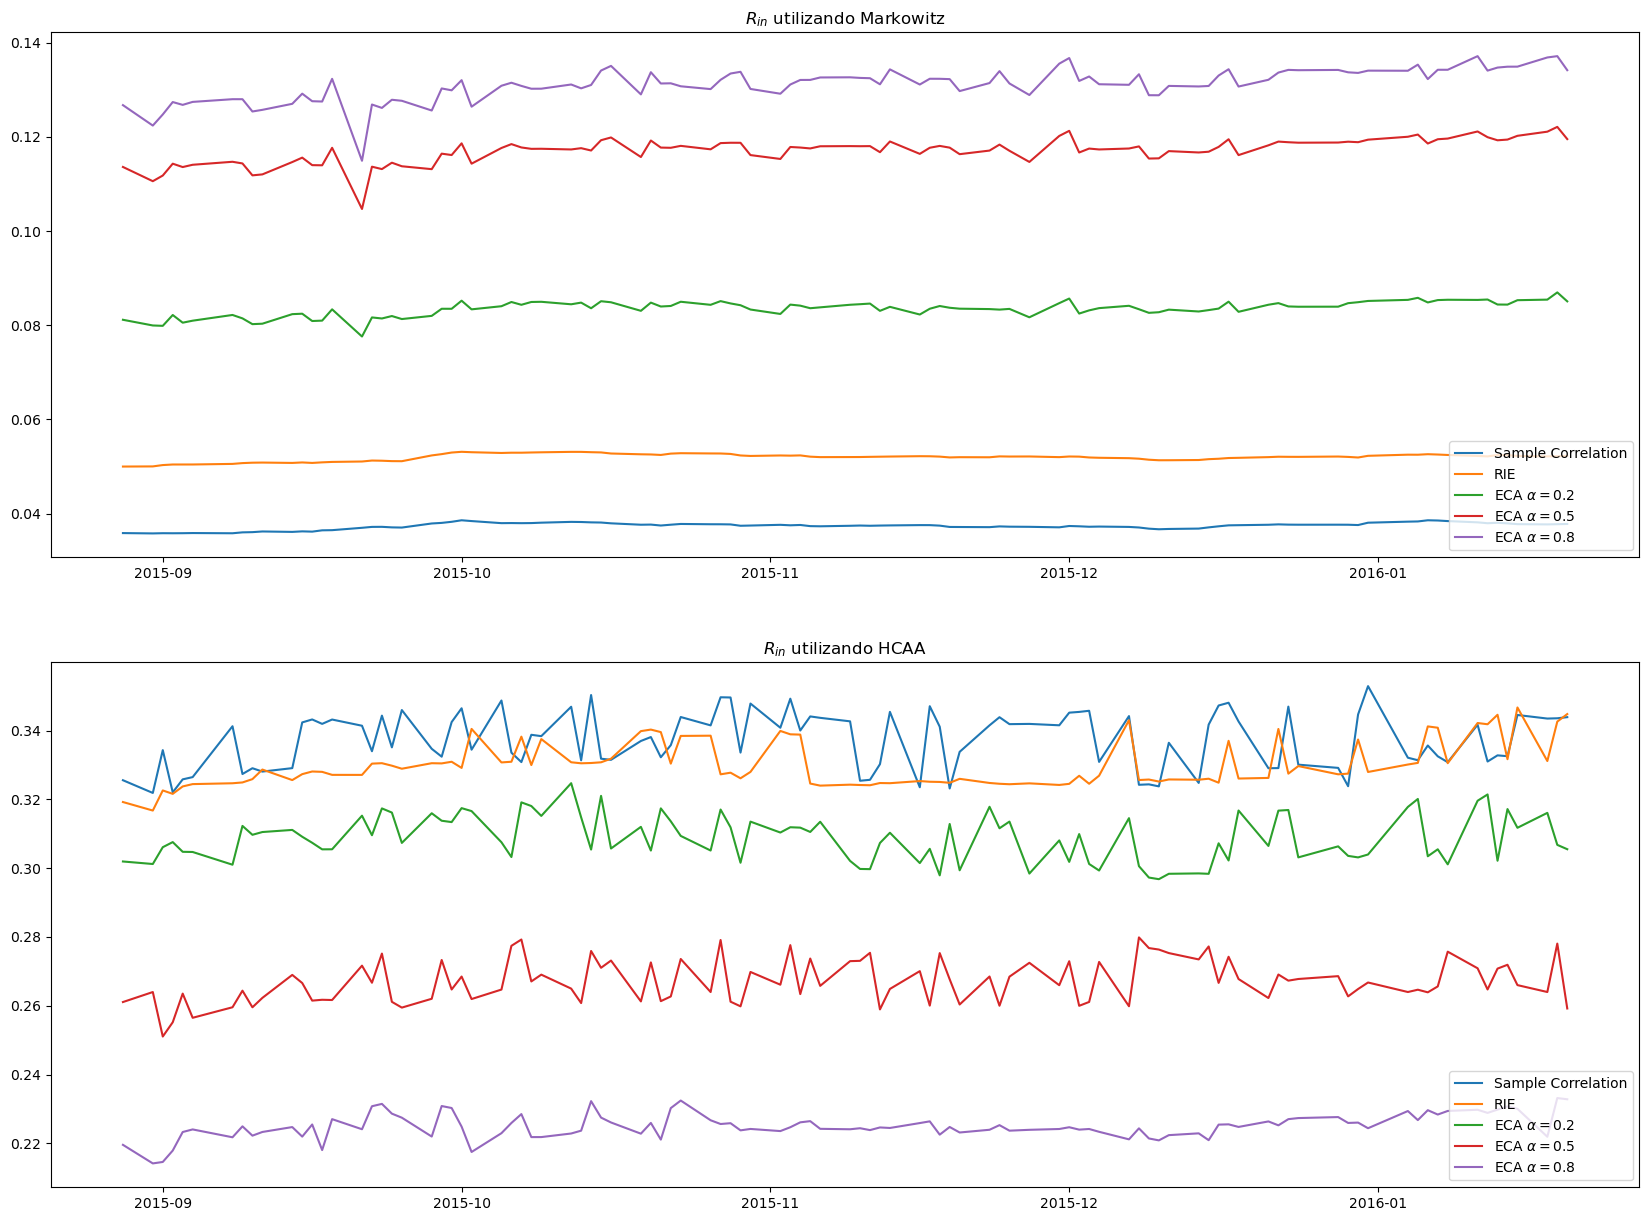

In [44]:
fig, ax = plt.subplots(2,1)
fig.set_size_inches(20.5, 15)

ax[0].plot(r_cuad_sample_df['values'], label = 'Sample Correlation')
ax[0].plot(r_cuad_rie_df['values'], label = 'RIE')
ax[0].plot(r_cuad_eca_2_df['values'], label = r'ECA $\alpha = 0.2$')
ax[0].plot(r_cuad_eca_5_df['values'], label = r'ECA $\alpha = 0.5$')
ax[0].plot(r_cuad_eca_8_df['values'], label = r'ECA $\alpha = 0.8$')
ax[0].legend(loc = 'lower right')
ax[0].set_title(r'$R_{in}$ utilizando Markowitz')

ax[1].plot(r_cuad_sample_hcaa_df['values'], label = 'Sample Correlation')
ax[1].plot(r_cuad_rie_hcaa_df['values'], label = 'RIE')
ax[1].plot(r_cuad_eca_2_hcaa_df['values'], label = r'ECA $\alpha = 0.2$')
ax[1].plot(r_cuad_eca_5_hcaa_df['values'], label = r'ECA $\alpha = 0.5$')
ax[1].plot(r_cuad_eca_8_hcaa_df['values'], label = r'ECA $\alpha = 0.8$')
ax[1].legend(loc = 'lower right')
ax[1].set_title(r'$R_{in}$ utilizando HCAA')


Text(0.5, 1.0, 'IPR utilizando HCAA')

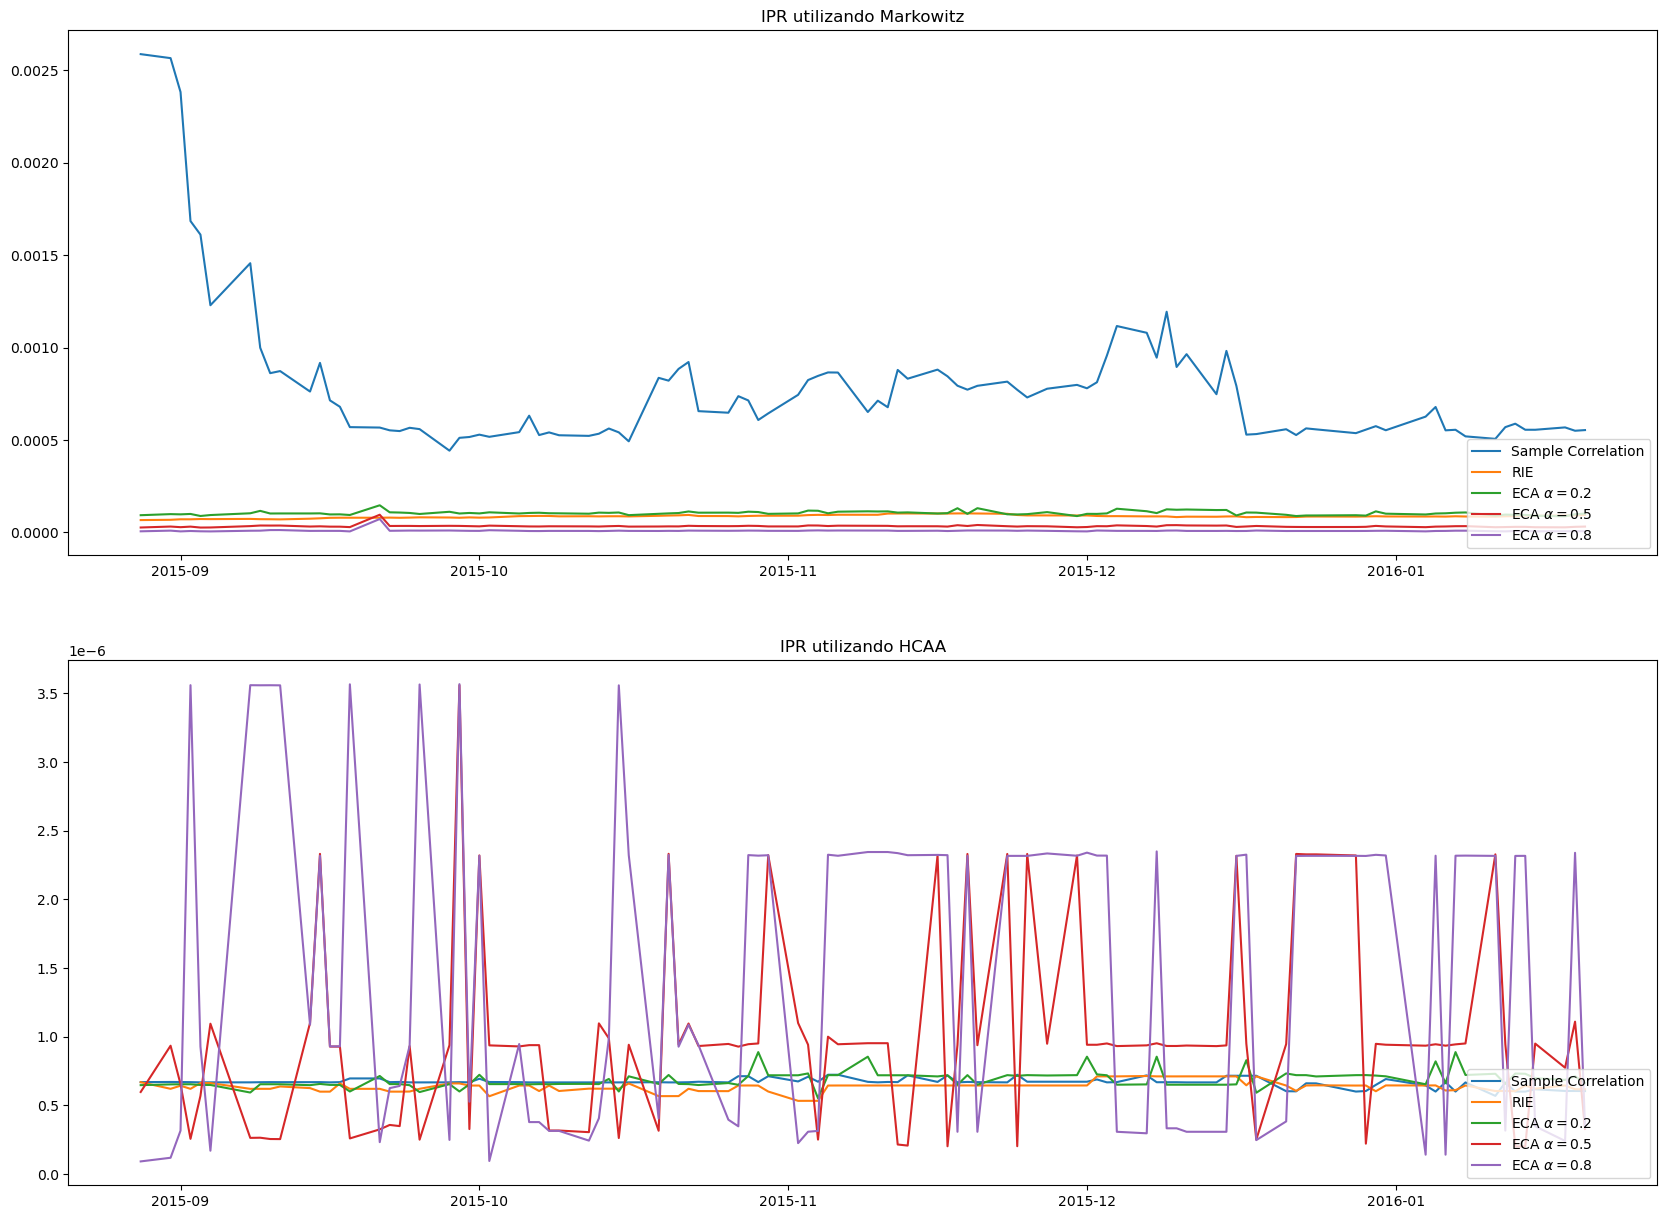

In [45]:
fig, ax = plt.subplots(2,1)
fig.set_size_inches(20.5, 15)
ax[0].plot(ipr_mark_sample_df['values'], label = 'Sample Correlation')
ax[0].plot(ipr_mark_rie_df['values'], label = 'RIE')
ax[0].plot(ipr_mark_eca_2_df['values'], label = r'ECA $\alpha = 0.2$')
ax[0].plot(ipr_mark_eca_5_df['values'], label = r'ECA $\alpha = 0.5$')
ax[0].plot(ipr_mark_eca_8_df['values'], label = r'ECA $\alpha = 0.8$')
ax[0].legend(loc = 'lower right')
ax[0].set_title('IPR utilizando Markowitz')

ax[1].plot(ipr_mark_sample_hcaa_df['values'], label = 'Sample Correlation')
ax[1].plot(ipr_mark_rie_hcaa_df['values'], label = 'RIE')
ax[1].plot(ipr_mark_eca_2_hcaa_df['values'], label = r'ECA $\alpha = 0.2$')
ax[1].plot(ipr_mark_eca_5_hcaa_df['values'], label = r'ECA $\alpha = 0.5$')
ax[1].plot(ipr_mark_eca_8_hcaa_df['values'], label = r'ECA $\alpha = 0.8$')
ax[1].legend(loc = 'lower right')
ax[1].set_title('IPR utilizando HCAA');

## Probar cuando el IPR es mayor y cuando es menor

In [3]:
test_1 = np.zeros(500) 
test_1[0] = 1
test_1

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [4]:
test_2 = np.ones(500)
test_2 = test_2 * 1/500
test_2


array([0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
       0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
       0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
       0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
       0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
       0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
       0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
       0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
       0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
       0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
       0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
       0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
       0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
       0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
       0.002, 0.002,

In [5]:
(np.abs(test_1)**4).sum()

1.0

In [6]:
(np.abs(test_2)**4).sum()

7.999999999999999e-09

# Hacer gráficas

Notar que estos dataframes vienen de correr el proceso de las ventanas (que tarda mucho y requiere buenos recursos) en google notebooks.

https://colab.research.google.com/drive/1tNU_-gBv7g76uuXYqQEff_tZiAPEYRTO#scrollTo=hvuTf8PaHnFB

In [21]:
ipr_mark_sample_df = pd.read_csv('ipr_dataframes/ipr_mark_sample_df.csv', index_col=0,parse_dates=True)
ipr_mark_rie_df = pd.read_csv('ipr_dataframes/ipr_mark_rie_df.csv', index_col=0, parse_dates=True)
ipr_mark_eca_2_df = pd.read_csv('ipr_dataframes/ipr_mark_eca_2_df.csv', index_col=0, parse_dates=True)
ipr_mark_eca_5_df = pd.read_csv('ipr_dataframes/ipr_mark_eca_5_df.csv', index_col=0, parse_dates=True)
ipr_mark_eca_8_df = pd.read_csv('ipr_dataframes/ipr_mark_eca_8_df.csv', index_col=0, parse_dates=True)
ipr_mark_sample_hcaa_df = pd.read_csv('ipr_dataframes/ipr_mark_sample_hcaa_df.csv', index_col=0, parse_dates=True)
ipr_mark_rie_hcaa_df = pd.read_csv('ipr_dataframes/ipr_mark_rie_hcaa_df.csv', index_col=0, parse_dates=True)
ipr_mark_eca_2_hcaa_df = pd.read_csv('ipr_dataframes/ipr_mark_eca_2_hcaa_df.csv', index_col=0, parse_dates=True)
ipr_mark_eca_5_hcaa_df = pd.read_csv('ipr_dataframes/ipr_mark_eca_5_hcaa_df.csv', index_col=0, parse_dates=True)
ipr_mark_eca_8_hcaa_df = pd.read_csv('ipr_dataframes/ipr_mark_eca_8_hcaa_df.csv', index_col=0, parse_dates=True)

Text(0.5, 0, 'Fecha')

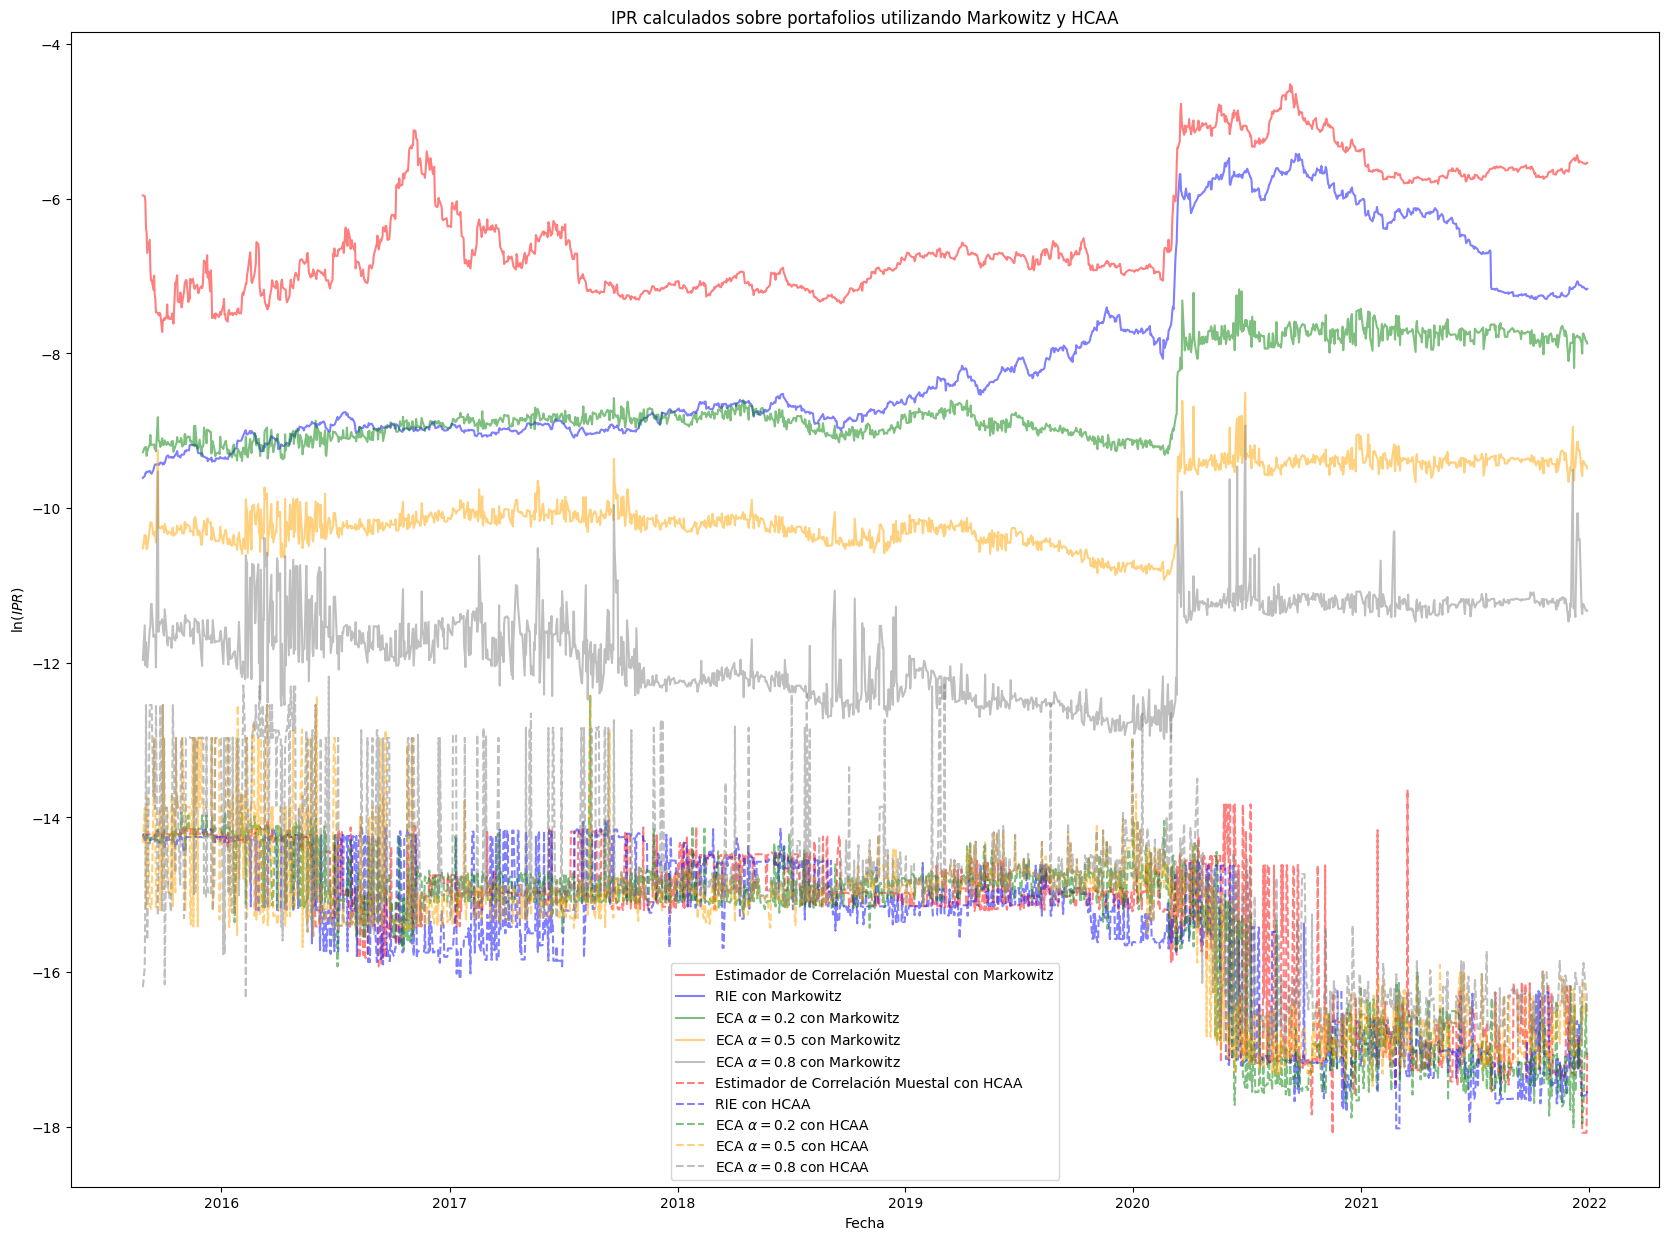

In [41]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(20.5, 15)
ax.plot(np.log(ipr_mark_sample_df['values']), label = 'Estimador de Correlación Muestal con Markowitz', color = 'red', alpha = 0.5)
ax.plot(np.log(ipr_mark_rie_df['values']), label = 'RIE con Markowitz', color = 'blue', alpha = 0.5)
ax.plot(np.log(ipr_mark_eca_2_df['values']), label = r'ECA $\alpha = 0.2$ con Markowitz', color = 'green', alpha = 0.5)
ax.plot(np.log(ipr_mark_eca_5_df['values']), label = r'ECA $\alpha = 0.5$ con Markowitz', color = 'orange', alpha = 0.5)
ax.plot(np.log(ipr_mark_eca_8_df['values']), label = r'ECA $\alpha = 0.8$ con Markowitz', color = 'grey', alpha = 0.5)


ax.plot(np.log(ipr_mark_sample_hcaa_df['values']), label = 'Estimador de Correlación Muestal con HCAA', color = 'red', ls = '--', alpha = 0.5)
ax.plot(np.log(ipr_mark_rie_hcaa_df['values']), label = 'RIE con HCAA', color = 'blue', ls = '--', alpha = 0.5)
ax.plot(np.log(ipr_mark_eca_2_hcaa_df['values']), label = r'ECA $\alpha = 0.2$ con HCAA', color = 'green', ls = '--', alpha = 0.5)
ax.plot(np.log(ipr_mark_eca_5_hcaa_df['values']), label = r'ECA $\alpha = 0.5$ con HCAA', color = 'orange', ls = '--', alpha = 0.5)
ax.plot(np.log(ipr_mark_eca_8_hcaa_df['values']), label = r'ECA $\alpha = 0.8$ con HCAA', color = 'grey', ls = '--', alpha = 0.5)

#ax.legend(loc = 'lower left')
ax.legend()
ax.set_title('IPR calculados sobre portafolios utilizando Markowitz y HCAA')
ax.set_ylabel(r"$\ln(IPR)$")
ax.set_xlabel(r"Fecha")